In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from enum import Enum

# Basics of Python data handling and visualization
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm import tqdm_notebook as tqdm

# Machine learning
import lightgbm as lgb
from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

C:\Users\Irena\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Dimension of the area is 249870 x 171656 m2


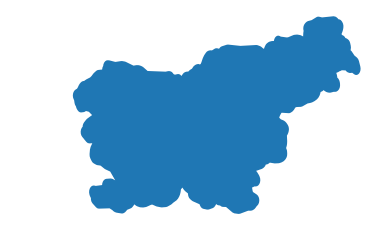

In [2]:
# Folder where data for running the notebook is stored
DATA_FOLDER = os.path.join(r"C:\Users\Irena\Desktop\ProjectEO\eo-learn-master\eo-learn-master", "example_data")

# Load geojson file
country = gpd.read_file(os.path.join(DATA_FOLDER, 'svn_buffered.geojson'))

# Convert CRS to UTM_33N
country_crs = CRS.UTM_33N
country = country.to_crs(crs={'init': CRS.ogc_string(country_crs)})

# Get the country's shape in polygon format
country_shape = country.geometry.values.tolist()[-1]

# Plot country
country.plot()
plt.axis('off');

# Print size
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2] - country_shape.bounds[0],
                                                             country_shape.bounds[3] - country_shape.bounds[1]))

In [3]:
use_smaller_patches = True

# Create the splitter to obtain a list of bboxes
bbox_splitter_large = BBoxSplitter([country_shape], country_crs, (25, 17))
bbox_splitter_small = BBoxSplitter([country_shape], country_crs, (25 * 3, 17 * 3))

bbox_splitter = bbox_splitter_small if use_smaller_patches else bbox_splitter_large

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# For the future examples, we will be using a specific set of patches,
# but you are free to change the patch ID numbers in the scope of this example
# Select a central patch
ID = 1549 if use_smaller_patches else 190

# Obtain surrounding patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)

# Check if final size is 3x3
if len(patchIDs) != 9:
    print('Warning! Use a different central patch ID, this one is on the border.')

# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3, 3))).ravel()

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]

gdf = gpd.GeoDataFrame({'index_x': idxs_x, 'index_y': idxs_y},
                       crs={'init': CRS.ogc_string(country_crs)},
                       geometry=geometry)

# save to shapefile
shapefile_name = './selected_3x3_bboxes_slovenia_small.shp' if use_smaller_patches \
    else './selected_3x3_bboxes_slovenia_large.shp'
gdf.to_file(shapefile_name)

In [4]:
poly = gdf['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)

# content of the geopandas dataframe
gdf.head()

index_x  index_y                                           geometry
0       42       29  POLYGON ((510157.6172221425 5122327.229129893,...
1       43       29  POLYGON ((513489.214628833 5122327.229129893, ...
2       44       29  POLYGON ((516820.8120355235 5122327.229129893,...
3       42       28  POLYGON ((510157.6172221425 5118961.421479214,...
4       43       28  POLYGON ((513489.214628833 5118961.421479214, ...

(357737.03586605104, 632593.8219180192, 5016135.9977509845, 5204957.80695405)

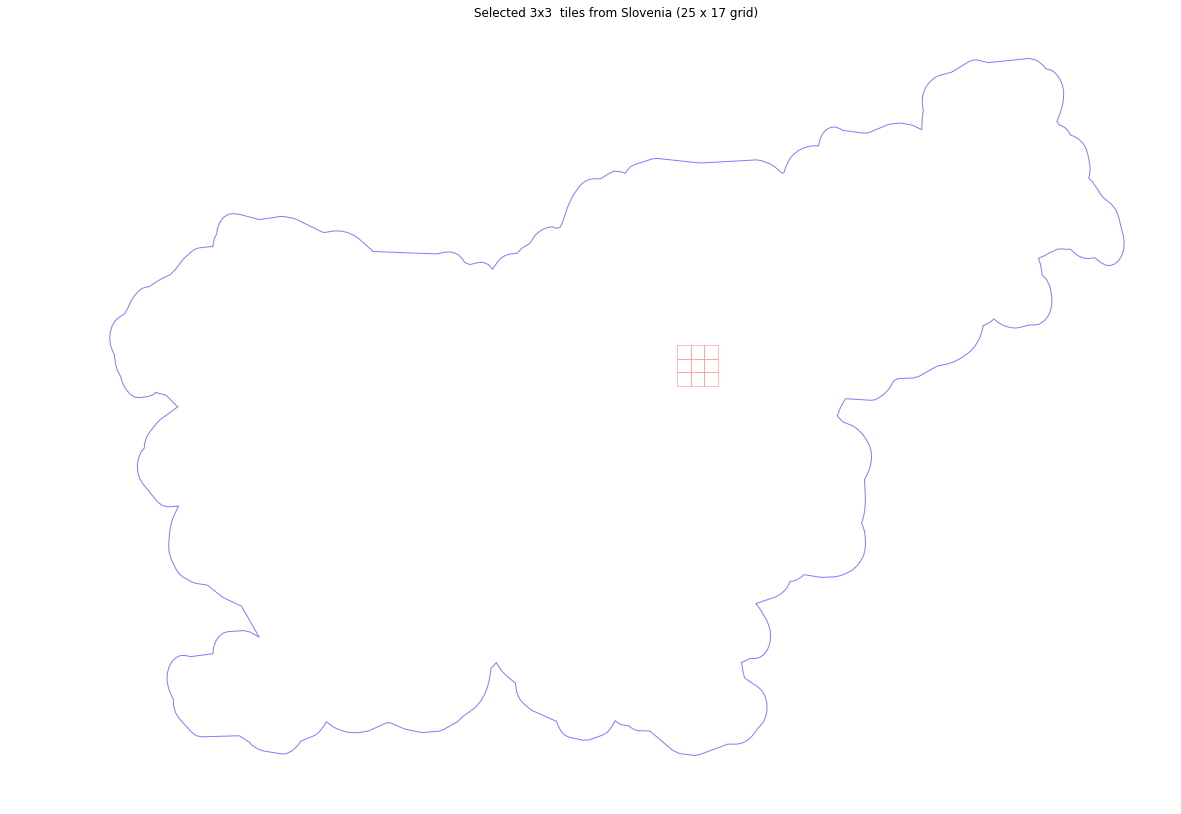

In [5]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu - xl) / 3, (yu - yl) / 5

# figure
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 3x3  tiles from Slovenia (25 x 17 grid)');
plt.axis('off')

In [6]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool),
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

class CountValid(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))

        return eopatch


class NormalizedDifferenceIndex(EOTask):
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])

    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]

        ndi = (band_a - band_b) / (band_a  + band_b)

        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])

        return eopatch


class EuclideanNorm(EOTask):
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name

    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))

        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch

In [7]:

# TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12)
# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover
# detection is performed in the next step
custom_script = 'return [B02, B03, B04, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C',
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution
# and the resulting cloud probability map and mask
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m',
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(),
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [8]:

class LULC(Enum):
    NO_DATA            = (0,  'No Data',            'white')
    CULTIVATED_LAND    = (1,  'Cultivated Land',    'xkcd:lime')
    FOREST             = (2,  'Forest',             'xkcd:darkgreen')
    GRASSLAND          = (3,  'Grassland',          'orange')
    SHRUBLAND          = (4,  'Shrubland',          'xkcd:tan')
    WATER              = (5,  'Water',              'xkcd:azure')
    WETLAND            = (6,  'Wetlands',           'xkcd:lightblue')
    TUNDRA             = (7,  'Tundra',             'xkcd:lavender')
    ARTIFICIAL_SURFACE = (8,  'Artificial Surface', 'crimson')
    BARELAND           = (9,  'Bareland',           'xkcd:beige')
    SNOW_AND_ICE       = (10, 'Snow and Ice',       'black')

    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

# example usecase
# LULC.BARELAND.id   # return 9

# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), lulc_cmap.N)

In [9]:

name_str = 'small' if use_smaller_patches else 'large'
land_cover_path = os.path.join(DATA_FOLDER, 'land_cover_subset_{}'.format(name_str),
                               'land_cover_subset_{}.shp'.format(name_str))

land_cover_data = gpd.read_file(land_cover_path)

rasterization_task = VectorToRaster(land_cover_data, (FeatureType.MASK_TIMELESS, 'LULC'),
                                    values_column='lulcid', raster_shape=(FeatureType.MASK, 'IS_VALID'),
                                    raster_dtype=np.uint8)

C:\Users\Irena\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


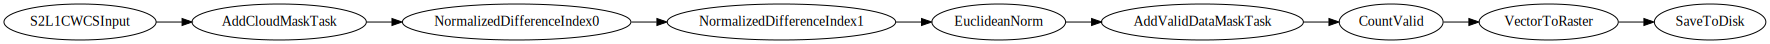

In [10]:
# Define the workflow
workflow = LinearWorkflow(
    add_data,
    add_clm,
    ndvi,
    ndwi,
    norm,
    add_sh_valmask,
    count_val_sh,
    rasterization_task,
    save
)

# Let's visualize it
workflow.dependency_graph()

In [11]:
%%time

# Execute the workflow
time_interval = ['2017-01-01', '2017-12-31'] # time interval for the SH request

# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    })

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=False)

executor.make_report()


Wall time: 2.44 s


EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(69, 337, 333, 6), dtype=float32)
    CLP: numpy.ndarray(shape=(69, 337, 333, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(69, 337, 333, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(69, 337, 333, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(69, 337, 333, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(69, 337, 333, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(69, 337, 333, 1), dtype=bool)
    IS_VALID: numpy.ndarray(shape=(69, 337, 333, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC: numpy.ndarray(shape=(337, 333, 1), dtype=uint8)
    VALID_COUNT: numpy.ndarray(shape=(337, 333, 1), dtype=int64)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ['2017-01-01

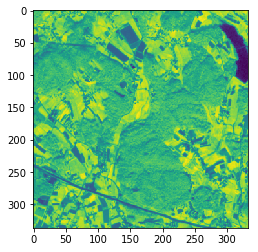

In [77]:
patch = EOPatch.load('./eopatches_small/eopatch_2/')

print(patch)
print(((patch.data['BANDS'][0][0])))

plt.imshow(patch.data['NDVI'][58].squeeze())
   


(337, 333, 3)
(337, 333, 3)
(337, 333, 3)
(337, 333, 3)
(337, 333, 3)
(337, 333, 3)
(337, 333, 3)
(337, 333, 3)
(337, 333, 3)


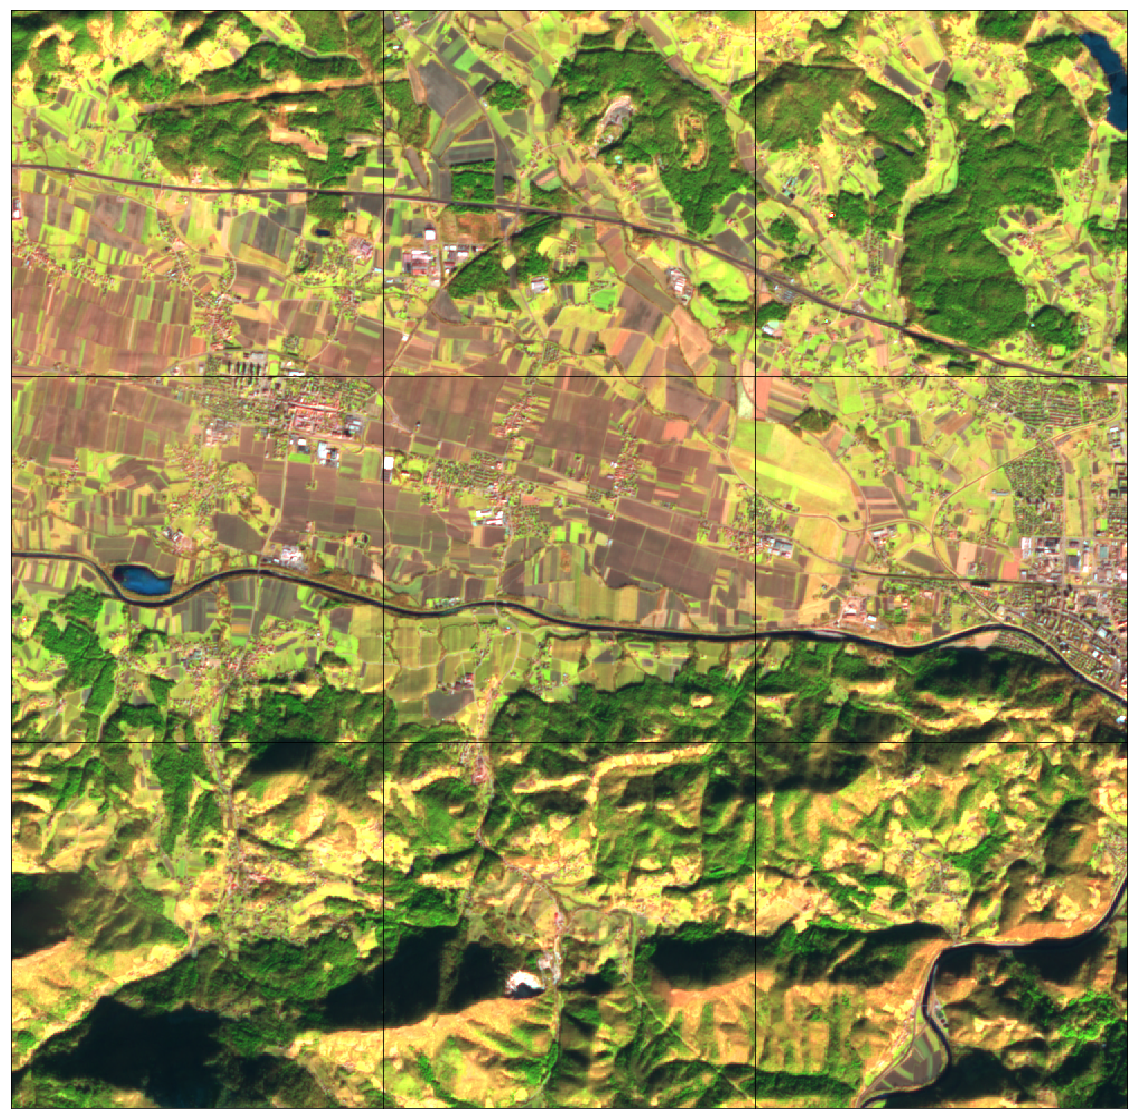

In [13]:
# Draw the RGB image
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
fig = plt.figure(figsize=(20, 20 * aspect_ratio))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.clip(eopatch.data['BANDS'][3][..., [4, 3, 2]]*3.5, 0, 1))
    print(eopatch.data['BANDS'][3][..., [4, 3, 2]].shape)
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

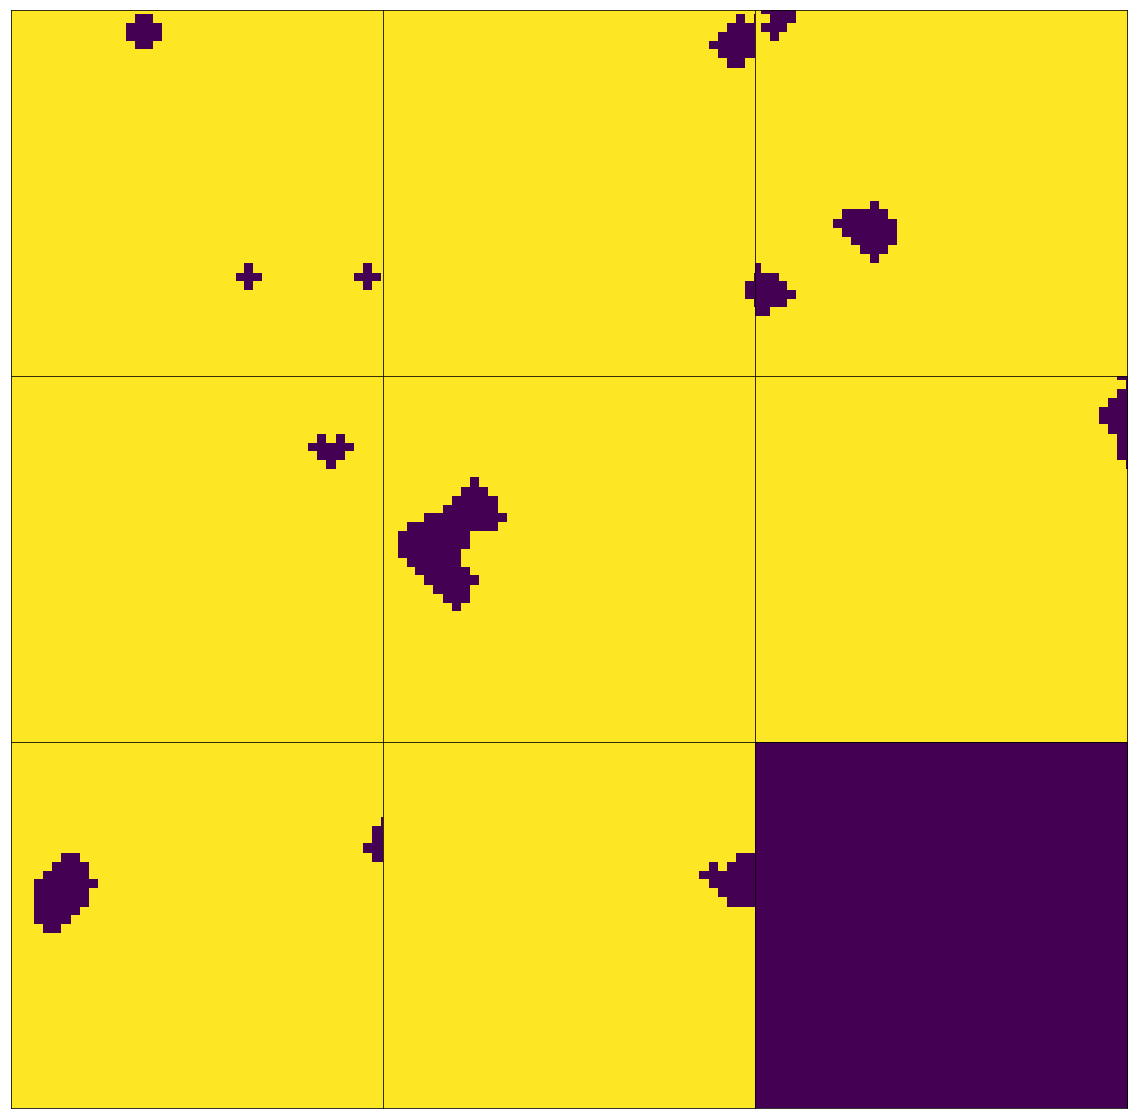

In [14]:
# Draw the NDVI image
fig = plt.figure(figsize=(20, 20 * aspect_ratio))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.clip(eopatch.mask['IS_VALID'][58].squeeze()*3.5, 0, 1))
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

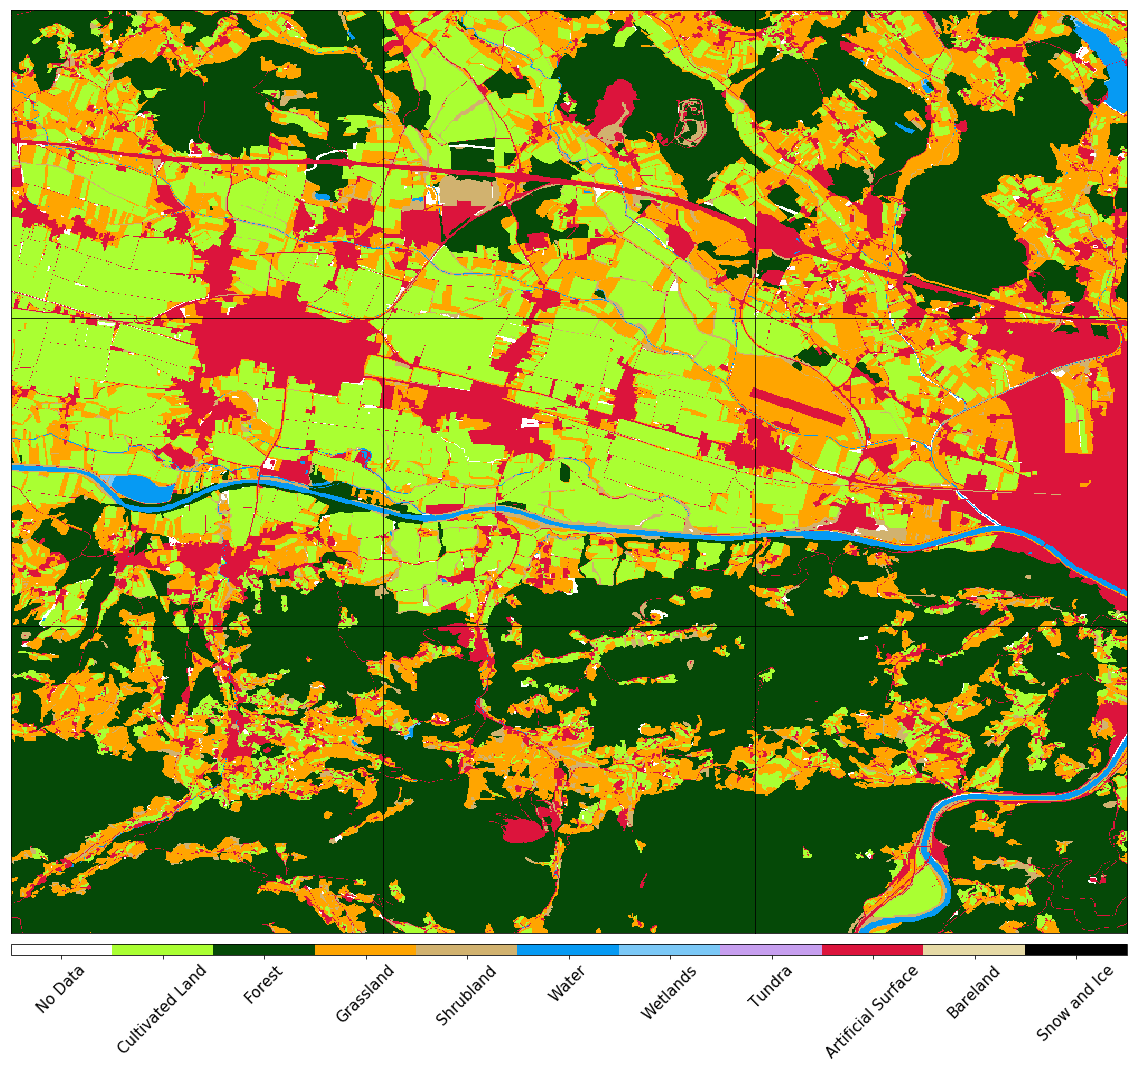

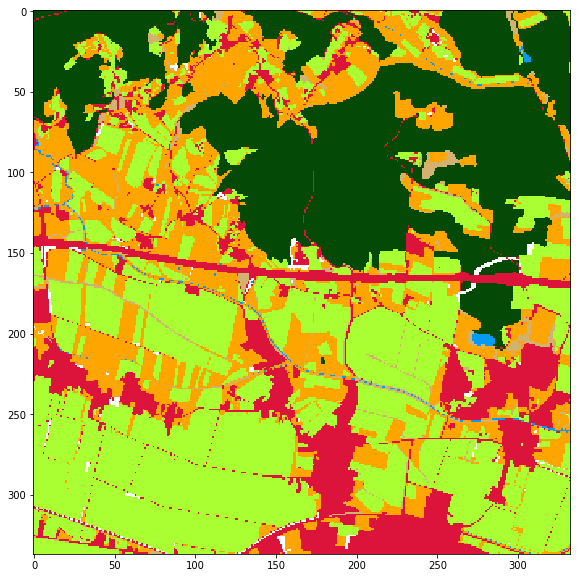

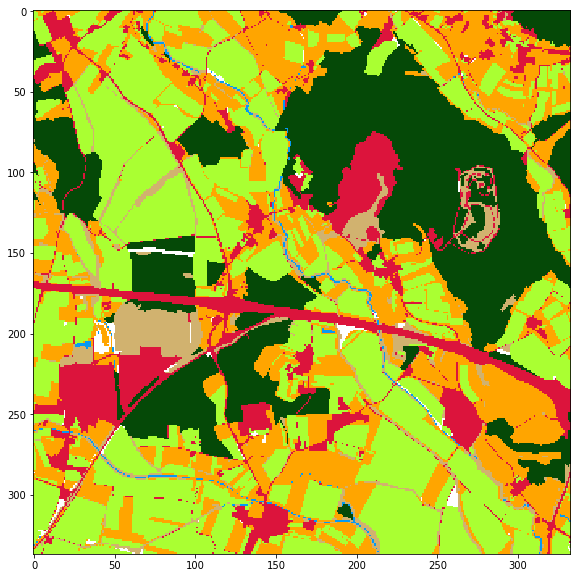

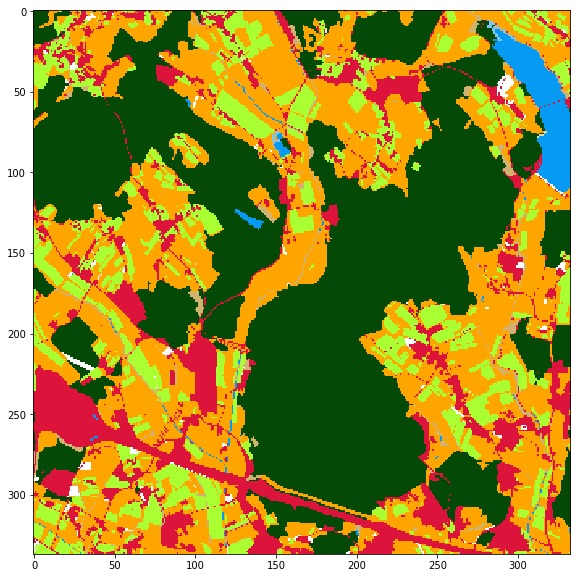

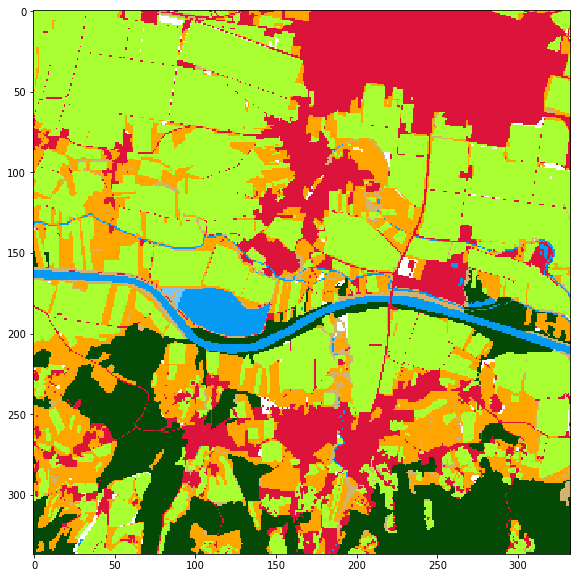

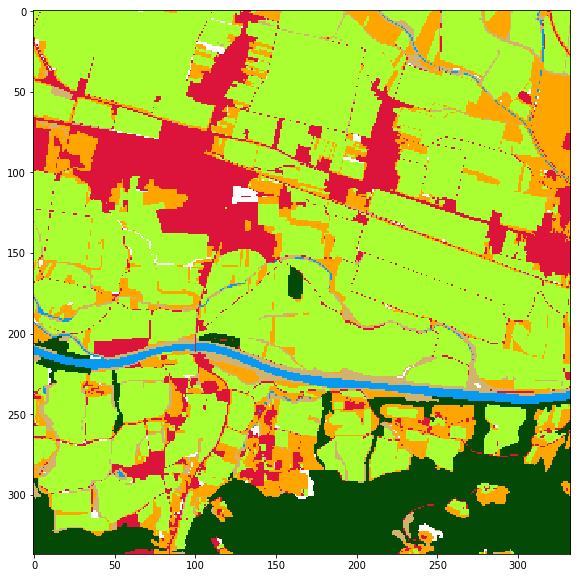

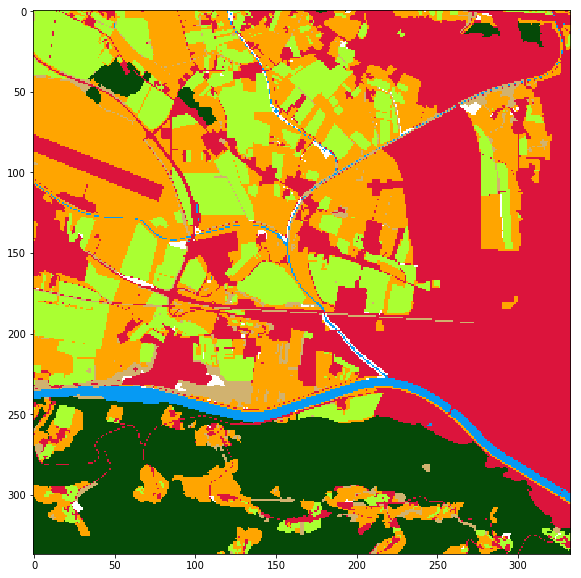

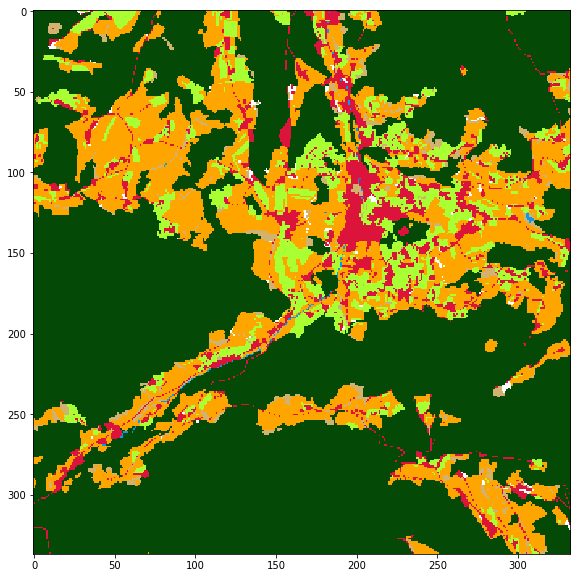

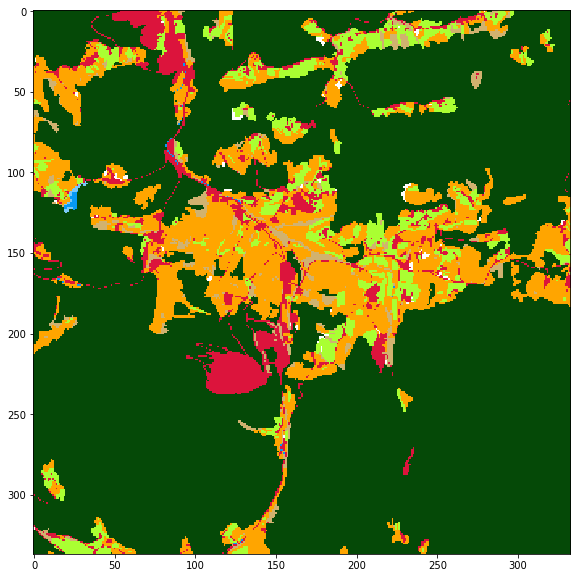

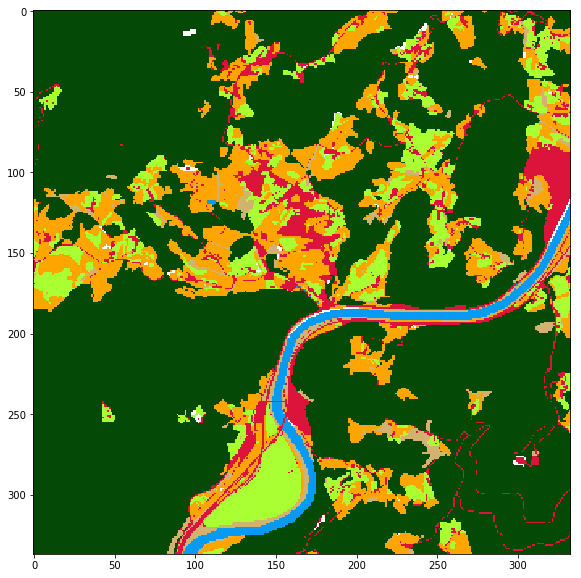

In [17]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)

pbar = tqdm(total=9)

for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    im = ax.imshow(eopatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    testpatch = eopatch
    plt.figure(figsize= (10, 10))
    plt.imshow(testpatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    
    
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.class_name for entry in LULC], rotation=45, fontsize=15)
plt.show()


(337, 333, 1)


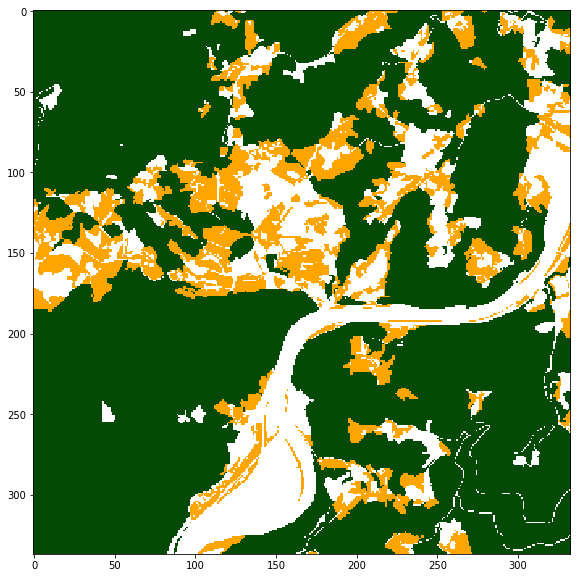

In [18]:
testpatch.data["BANDS"].shape
plt.figure(figsize= (10, 10))
plt.imshow(testpatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
print(testpatch.mask_timeless['LULC'].shape)
modified = []
for row in testpatch.mask_timeless['LULC']:
    modified.append([px[0] if (px == 2 or px == 3) else 0 for px in row])
    

plt.imshow(modified, cmap=lulc_cmap, norm=lulc_norm)

In [19]:

class Modified(Enum):
    NO_DATA            = (0,  'No Data',            'white')
    FOREST             = (2,  'Forest',             'xkcd:darkgreen')
    GRASSLAND          = (3,  'Grassland',          'orange')

    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

# Reference colormap things
Modified_cmap = mpl.colors.ListedColormap([entry.color for entry in Modified])
Modified_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), Modified_cmap.N)

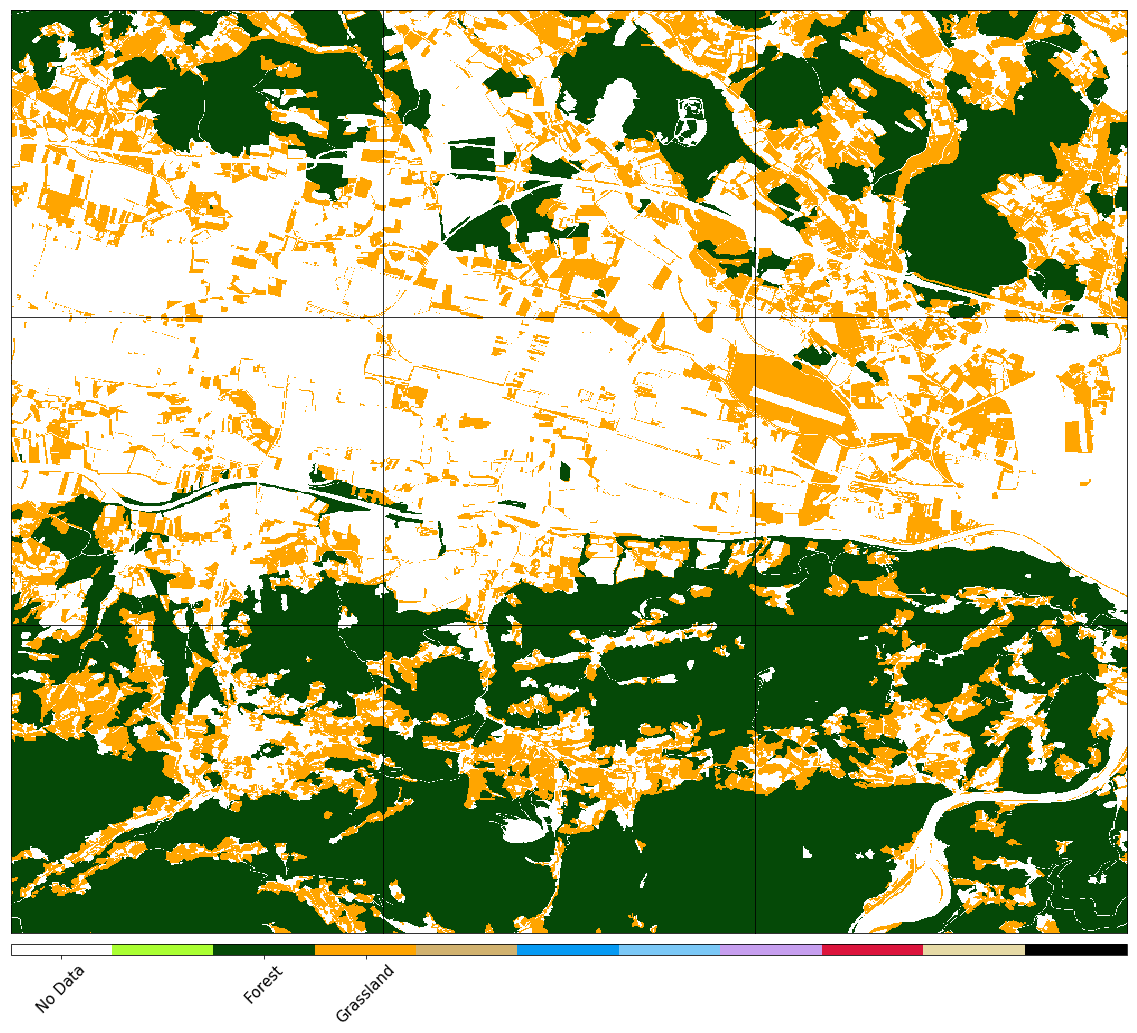

In [20]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)
y_patch = []
pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    modified = []
    for row in eopatch.mask_timeless['LULC']:
        modified.append([px[0] if (px == 2 or px == 3) else 0 for px in row])
    #plt.imshow(modified, cmap=lulc_cmap, norm=lulc_norm)
    im = ax.imshow(modified, cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    
    testpatch = eopatch
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.id for entry in Modified])
cb.ax.set_xticklabels([entry.class_name for entry in Modified], rotation=45, fontsize=15)
plt.show()

(337, 333, 1)
(337, 333, 1)
(337, 333, 1)
(337, 333, 1)
(337, 333, 1)
(337, 333, 1)
(337, 333, 1)
(337, 333, 1)
(337, 333, 1)


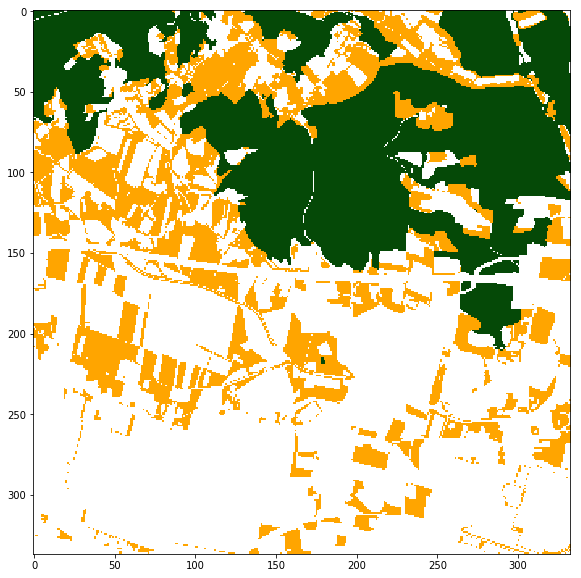

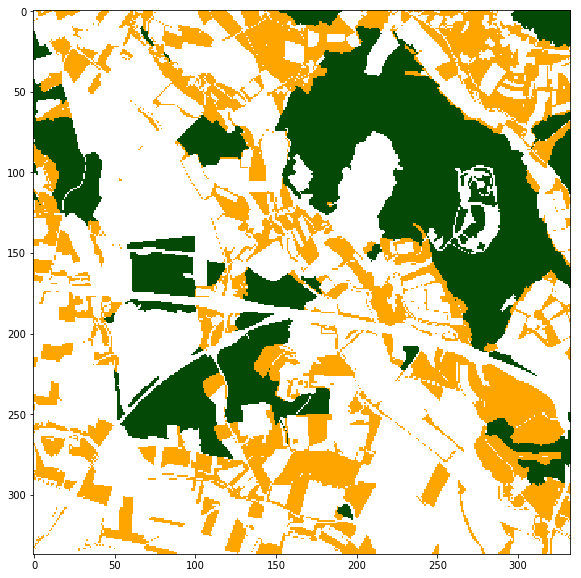

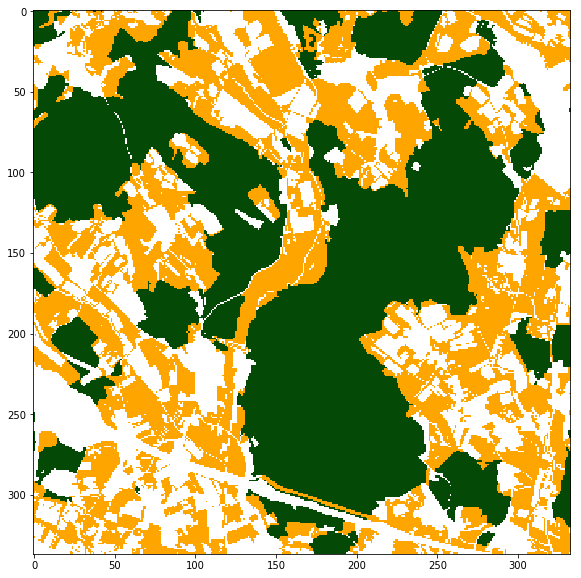

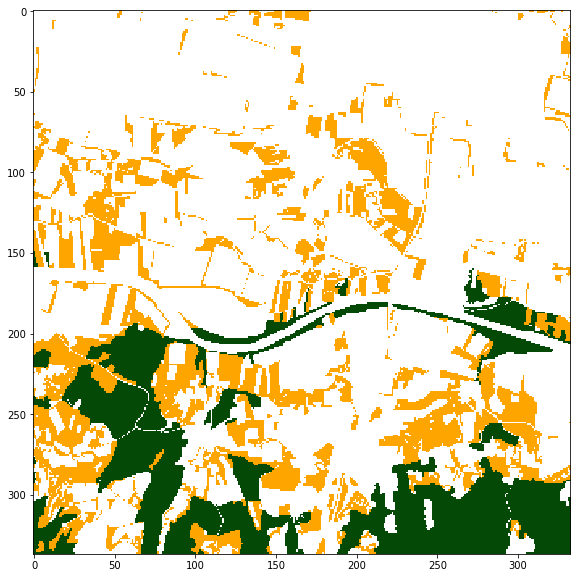

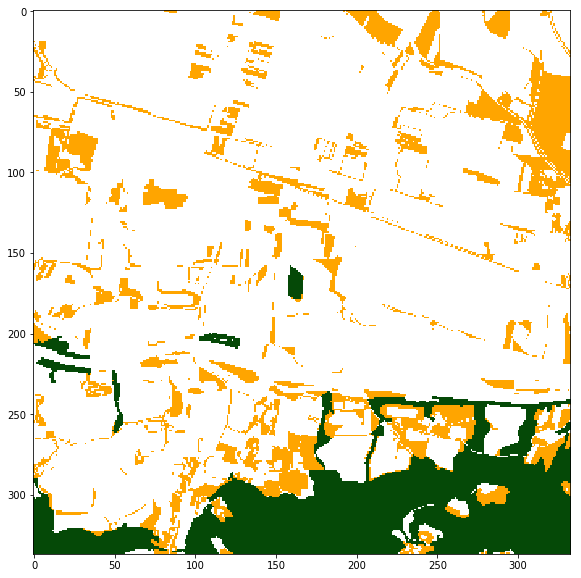

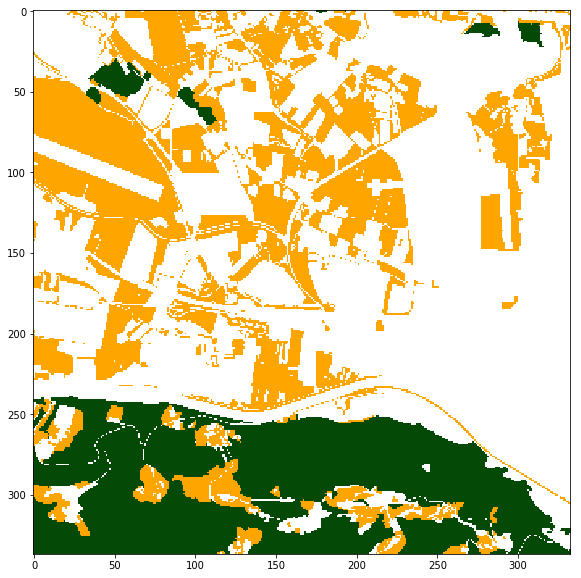

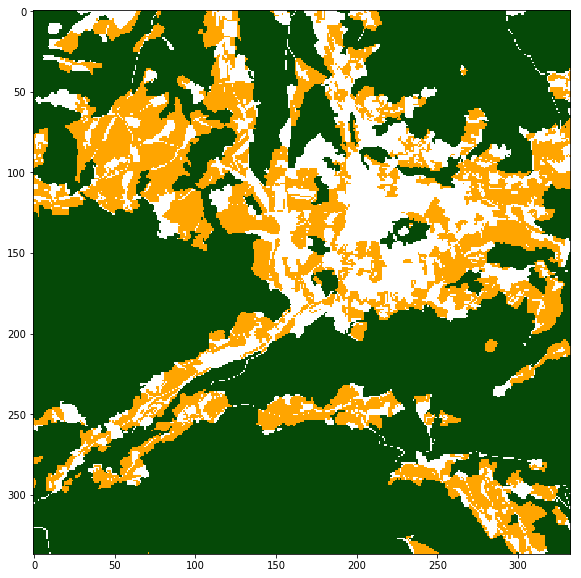

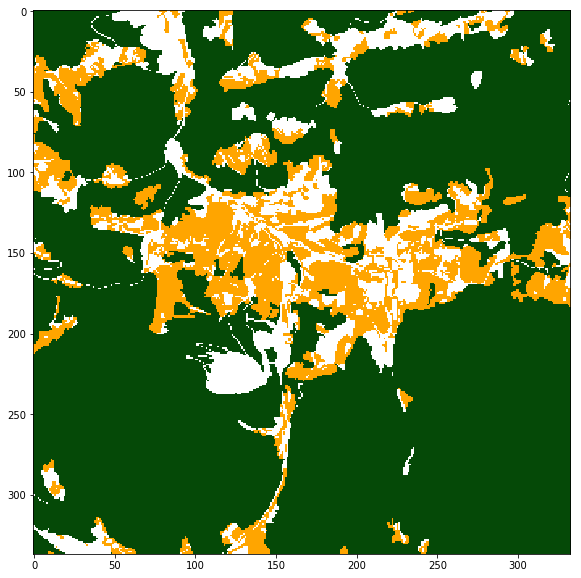

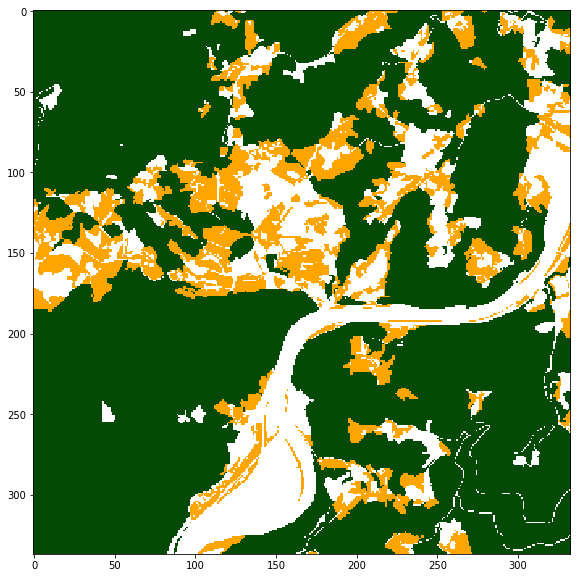

In [21]:
outpatches = []
for i, ax in enumerate(axes.flat):
    testpatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    testpatch.data["BANDS"].shape
    plt.figure(figsize= (10, 10))
    plt.imshow(testpatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    print(testpatch.mask_timeless['LULC'].shape)
    
    modified = []
    for row in testpatch.mask_timeless['LULC']:
        modified.append([px[0] if (px == 2 or px == 3) else 0 for px in row])
    modified = np.array(modified).reshape(337,333,1)
    outpatches.append(modified)
    


    plt.imshow(modified[:,:,0], cmap=lulc_cmap, norm=lulc_norm)

0
(337, 333, 1)


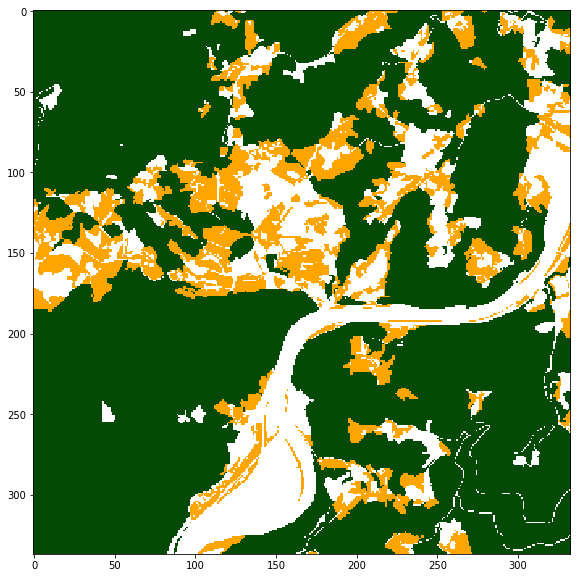

In [22]:
testpatch.data["BANDS"].shape
plt.figure(figsize= (10, 10))
plt.imshow(testpatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
modified = []
print(len(modified))
    
for row in testpatch.mask_timeless['LULC']:
    modified.append([px[0] if (px == 2 or px == 3) else 0 for px in row])
modified = np.array(modified).reshape(337,333,1)
print((modified).shape)  


plt.imshow(modified[:,:,0], cmap=lulc_cmap, norm=lulc_norm)

(69, 337, 333, 6)
(69, 337, 333, 6)
(69, 337, 333, 6)
(69, 337, 333, 6)
(69, 337, 333, 6)
(69, 337, 333, 6)
(69, 337, 333, 6)
(69, 337, 333, 6)
(69, 337, 333, 6)


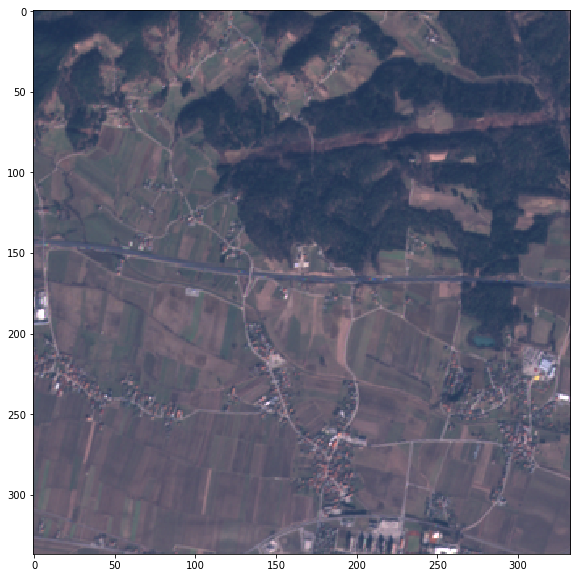

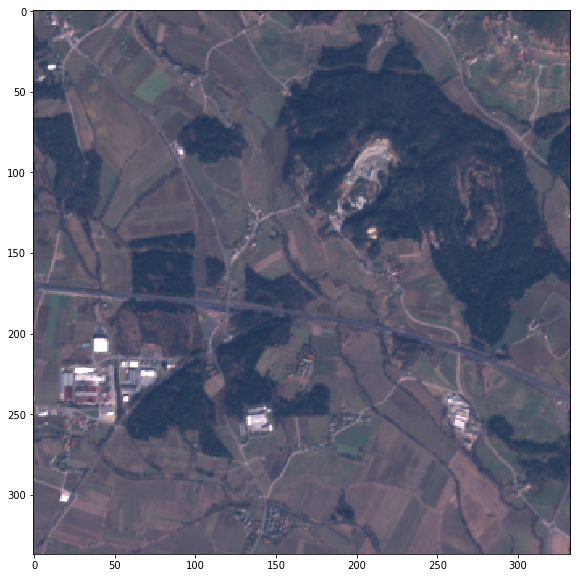

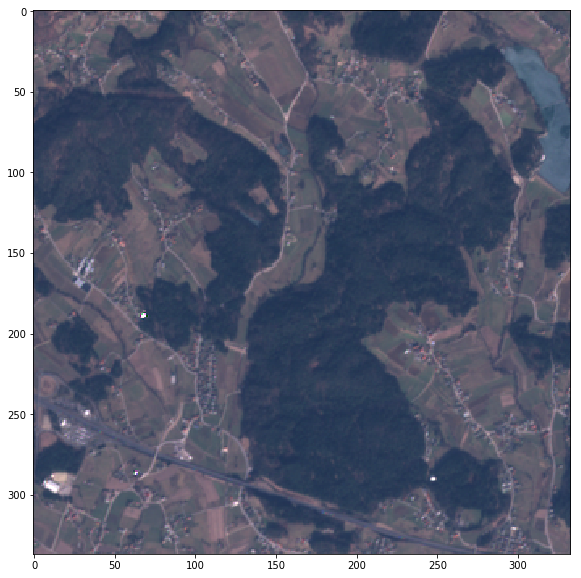

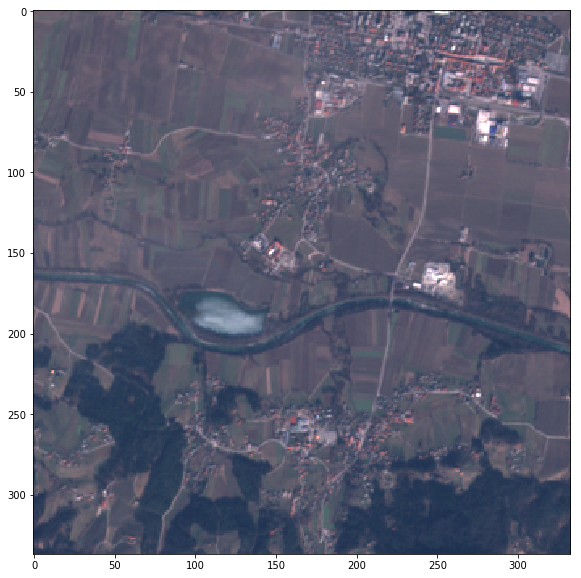

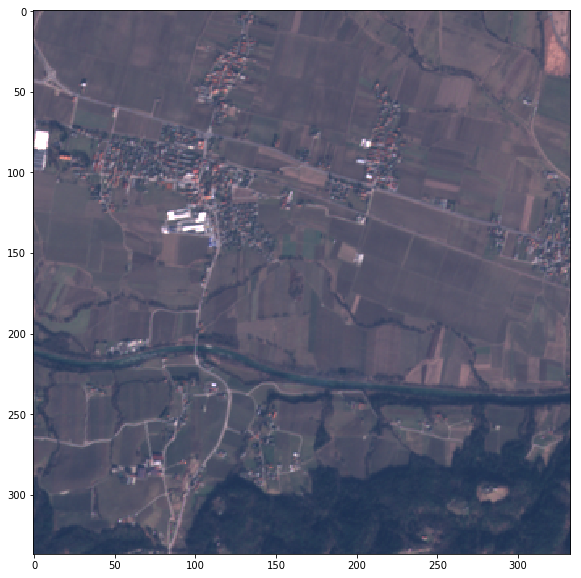

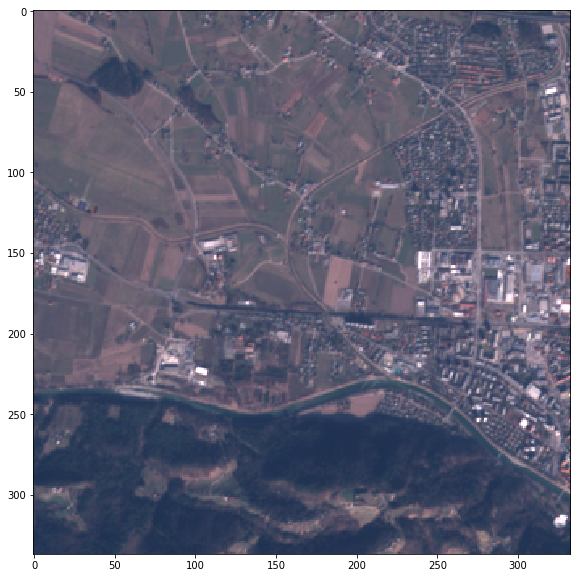

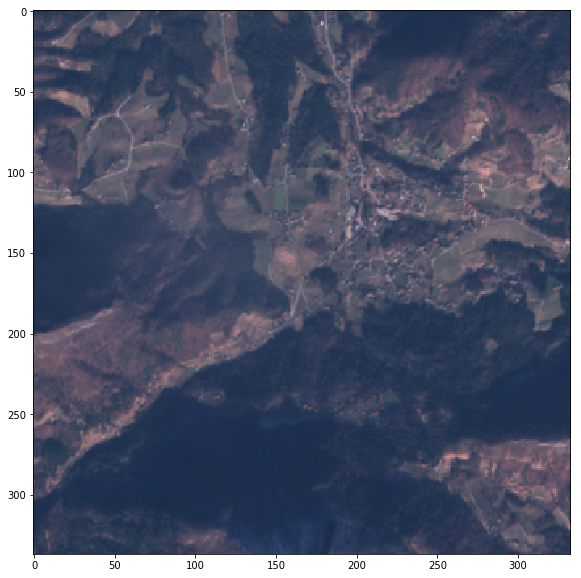

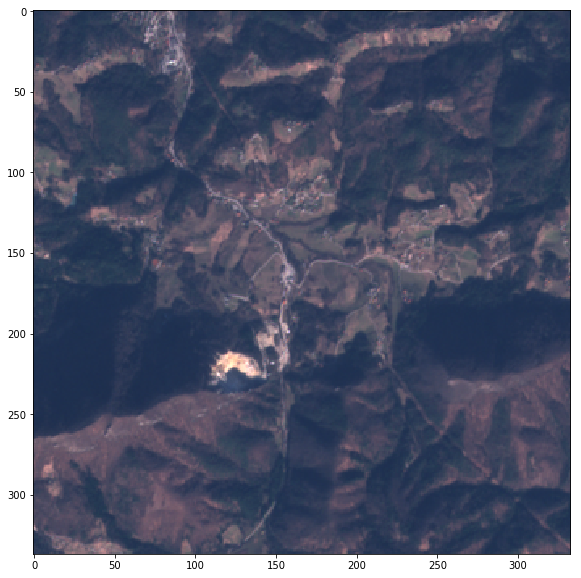

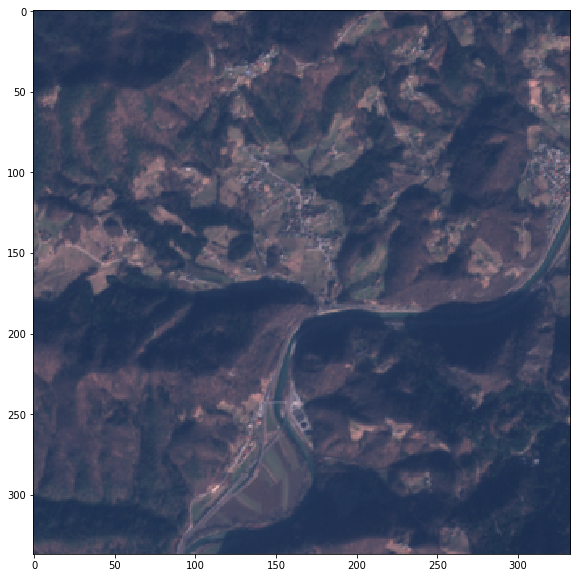

In [23]:
inpatches = []
for i, ax in enumerate(axes.flat):
    testpatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    print(testpatch.data["BANDS"].shape)
    plt.figure(figsize= (10, 10))
    plt.imshow(np.clip(testpatch.data['BANDS'][3][..., [2, 1, 0]]*3.5, 0, 1))
    inpatches.append(testpatch.data["BANDS"])
    
    
    



In [78]:
outpatches[2]


array([[[2],
        [2],
        [2],
        ...,
        [3],
        [3],
        [3]],

       [[2],
        [2],
        [2],
        ...,
        [3],
        [3],
        [3]],

       [[2],
        [2],
        [2],
        ...,
        [3],
        [3],
        [3]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [3],
        [3],
        [3]],

       [[0],
        [0],
        [0],
        ...,
        [3],
        [3],
        [3]],

       [[0],
        [0],
        [0],
        ...,
        [3],
        [3],
        [0]]])

In [25]:
print(inpatches[0].shape, outpatches[0].shape)

(69, 337, 333, 6) (337, 333, 1)


In [84]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
mlp = MLPClassifier()
X = []
for pth in inpatches[0]:
    X.append(pth[:,:,[2,1,0]])
print(X[0].shape)
outpatches[0].shape

(337, 333, 3)


(337, 333, 1)

In [85]:
mlp.fit(X[0], outpatches[0])

ValueError: Found array with dim 3. Estimator expected <= 2.

In [86]:
X_2d = X[0].reshape(337, 999)
y_2d = outpatches[0].reshape(337, 333)

In [87]:
print(X_2d.shape, y_2d.shape)

(337, 999) (337, 333)


In [88]:
mlp.fit(X_2d, y_2d)

ValueError: Multioutput target data is not supported with label binarization